# DDCGAN-based Fusion Model Testing

This notebook tests the trained DDCGAN-based CT-MRI fusion model with comprehensive evaluation metrics and visualizations.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Tuple, Dict, Any
import sys

# Add path to utils for metrics
sys.path.append('../medical_fusion_webapp')
from utils.metrics import evaluate_fusion_comprehensive, get_metric_descriptions

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
# DDCGAN Model Architecture (same as training)
class Block(nn.Module):
    def __init__(self, in_channels, filter_size, strides, kernel=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, filter_size, kernel, strides, kernel//2),
            nn.BatchNorm2d(filter_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):    
    def __init__(self, in_channels=2, out_channels=48, constant_feature_map=48):
        super().__init__()
        self.model = nn.Sequential(
            Block(in_channels, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, out_channels, 1)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):        
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(16, out_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, encoder_constant_features=48):
        super().__init__()
        self.encoder = Encoder(in_channels, encoder_constant_features, encoder_constant_features)
        self.decoder = Decoder(encoder_constant_features, out_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
# Dataset class for paired medical images (same as training)
class CTMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        # Find all image pairs
        self.image_pairs = []

        print(f"Scanning dataset directory: {root_dir}")

        # Simple structure: root_dir/CT/ and root_dir/MRI/
        ct_dir = os.path.join(root_dir, 'CT')
        mri_dir = os.path.join(root_dir, 'MRI')

        # Check if both directories exist
        if os.path.exists(ct_dir) and os.path.exists(mri_dir):
            print("Found CT and MRI directories")

            # Get all PNG files from both directories
            ct_files = sorted(glob.glob(os.path.join(ct_dir, '*.png')))
            mri_files = sorted(glob.glob(os.path.join(mri_dir, '*.png')))

            print(f"Found {len(ct_files)} CT images and {len(mri_files)} MRI images")

            # Match files by name (they should have the same names)
            for ct_file in ct_files:
                mri_file = os.path.join(mri_dir, os.path.basename(ct_file))
                if os.path.exists(mri_file):
                    self.image_pairs.append((ct_file, mri_file))
                else:
                    print(f"Warning: No matching MRI file for {os.path.basename(ct_file)}")

        else:
            print(f"Warning: Missing CT or MRI directory in {root_dir}")
            print(f"Expected: {ct_dir} and {mri_dir}")

        print(f"Found {len(self.image_pairs)} valid image pairs")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ct_path, mri_path = self.image_pairs[idx]

        try:
            # Load images
            ct_img = Image.open(ct_path).convert('RGB')
            mri_img = Image.open(mri_path).convert('RGB')

            # Convert to grayscale for fusion
            ct_gray = ct_img.convert('L')
            mri_gray = mri_img.convert('L')

            # Resize images
            ct_gray = ct_gray.resize(self.img_size, Image.Resampling.BILINEAR)
            mri_gray = mri_gray.resize(self.img_size, Image.Resampling.BILINEAR)

            # Convert to tensors and normalize to [-1, 1]
            if self.transform:
                ct_tensor = self.transform(ct_gray)
                mri_tensor = self.transform(mri_gray)
            else:
                ct_tensor = transforms.ToTensor()(ct_gray)
                mri_tensor = transforms.ToTensor()(mri_gray)
                ct_tensor = ct_tensor * 2.0 - 1.0
                mri_tensor = mri_tensor * 2.0 - 1.0

            return ct_tensor, mri_tensor, os.path.basename(ct_path)

        except Exception as e:
            print(f"Error loading image pair {ct_path}, {mri_path}: {e}")
            # Return dummy data if there's an error
            dummy_img = torch.rand(1, self.img_size[0], self.img_size[1]) * 2 - 1
            return dummy_img, dummy_img, f"error_{idx}"

In [4]:
# Configuration
dataset_path = '../Dataset/CT-MRI'
checkpoint_path = 'checkpoints/final/ddcgan_fusion/ddcgan_epoch_50.pth'
results_dir = 'test_results/ddcgan_fusion'
img_size = (256, 256)
batch_size = 4

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Load trained model
print("Loading trained DDCGAN fusion model...")
model = Generator(in_channels=2, out_channels=1).to(device)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['generator_state_dict'])
    print(f"✓ Loaded model from: {checkpoint_path}")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Generator loss: {checkpoint.get('g_losses', [-1])[-1]:.4f}")
    print(f"  - Discriminator loss: {checkpoint.get('d_losses', [-1])[-1]:.4f}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    print("Using untrained model for demonstration")

model.eval()

Loading trained DDCGAN fusion model...
✓ Loaded model from: checkpoints/final/ddcgan_fusion/ddcgan_epoch_50.pth
  - Trained for 50 epochs
  - Generator loss: 4.8829
  - Discriminator loss: 0.4424


Generator(
  (encoder): Encoder(
    (model): Sequential(
      (0): Block(
        (model): Sequential(
          (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): Block(
        (model): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): Block(
        (model): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Block(
        (model): Sequenti

In [5]:
# Prepare test dataset
print("Preparing test dataset...")
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

test_dataset = CTMRIDataset(dataset_path, transform=test_transform, img_size=img_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

# Function to run inference on test set
def run_inference(model, test_loader, device):
    """Run inference on test set and collect results."""
    model.eval()
    results = []
    
    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)
            
            # Concatenate CT and MRI images as input
            input_batch = torch.cat([ct_batch, mr_batch], dim=1)
            
            # Forward pass
            fused_batch = model(input_batch)
            
            # Convert to numpy for metrics calculation (denormalize from [-1,1] to [0,1])
            for i in range(len(keys)):
                ct_np = (ct_batch[i].squeeze().cpu().numpy() + 1) / 2
                mr_np = (mr_batch[i].squeeze().cpu().numpy() + 1) / 2
                fused_np = (fused_batch[i].squeeze().cpu().numpy() + 1) / 2
                
                results.append({
                    'key': keys[i],
                    'ct': ct_np,
                    'mr': mr_np,
                    'fused': fused_np
                })
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    return results

# Run inference
print("Running inference on test set...")
test_results = run_inference(model, test_loader, device)
print(f"✓ Inference completed. Processed {len(test_results)} image pairs.")

Preparing test dataset...
Scanning dataset directory: ../Dataset/CT-MRI
Found CT and MRI directories
Found 573 CT images and 573 MRI images
Found 573 valid image pairs
Test dataset size: 573
Test batches: 144
Running inference on test set...
Processed 10/144 batches
Processed 20/144 batches
Processed 30/144 batches
Processed 10/144 batches
Processed 20/144 batches
Processed 30/144 batches
Processed 40/144 batches
Processed 50/144 batches
Processed 40/144 batches
Processed 50/144 batches
Processed 60/144 batches
Processed 70/144 batches
Processed 60/144 batches
Processed 70/144 batches
Processed 80/144 batches
Processed 90/144 batches
Processed 80/144 batches
Processed 90/144 batches
Processed 100/144 batches
Processed 100/144 batches
Processed 110/144 batches
Processed 110/144 batches
Processed 120/144 batches
Processed 130/144 batches
Processed 120/144 batches
Processed 130/144 batches
Processed 140/144 batches
✓ Inference completed. Processed 573 image pairs.
Processed 140/144 batche

In [6]:
# Calculate comprehensive metrics
print("Calculating evaluation metrics...")

all_metrics = []
for i, result in enumerate(test_results):
    metrics = evaluate_fusion_comprehensive(
        result['fused'], 
        result['ct'], 
        result['mr']
    )
    metrics['sample_id'] = i
    metrics['key'] = result['key']
    all_metrics.append(metrics)
    
    if (i + 1) % 50 == 0:
        print(f"Calculated metrics for {i + 1}/{len(test_results)} samples")

# Convert to DataFrame for analysis
metrics_df = pd.DataFrame(all_metrics)
print(f"✓ Metrics calculated for {len(all_metrics)} samples")

# Display metric descriptions
print("\n" + "="*60)
print("METRIC DESCRIPTIONS:")
print("="*60)
descriptions = get_metric_descriptions()
for metric, desc in descriptions.items():
    if metric in metrics_df.columns:
        print(f"{metric:15}: {desc}")
print()

# Summary statistics
print("SUMMARY STATISTICS:")
print("="*60)
summary_stats = metrics_df.describe()
key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
print(summary_stats[key_metrics].round(4))

Calculating evaluation metrics...
Calculated metrics for 50/573 samples
Calculated metrics for 50/573 samples
Calculated metrics for 100/573 samples
Calculated metrics for 100/573 samples
Calculated metrics for 150/573 samples
Calculated metrics for 150/573 samples
Calculated metrics for 200/573 samples
Calculated metrics for 200/573 samples
Calculated metrics for 250/573 samples
Calculated metrics for 250/573 samples
Calculated metrics for 300/573 samples
Calculated metrics for 300/573 samples
Calculated metrics for 350/573 samples
Calculated metrics for 350/573 samples
Calculated metrics for 400/573 samples
Calculated metrics for 400/573 samples
Calculated metrics for 450/573 samples
Calculated metrics for 450/573 samples
Calculated metrics for 500/573 samples
Calculated metrics for 500/573 samples
Calculated metrics for 550/573 samples
Calculated metrics for 550/573 samples
✓ Metrics calculated for 573 samples

METRIC DESCRIPTIONS:
SSIM_Avg       : Average Structural Similarity Inde

Generating visualizations...


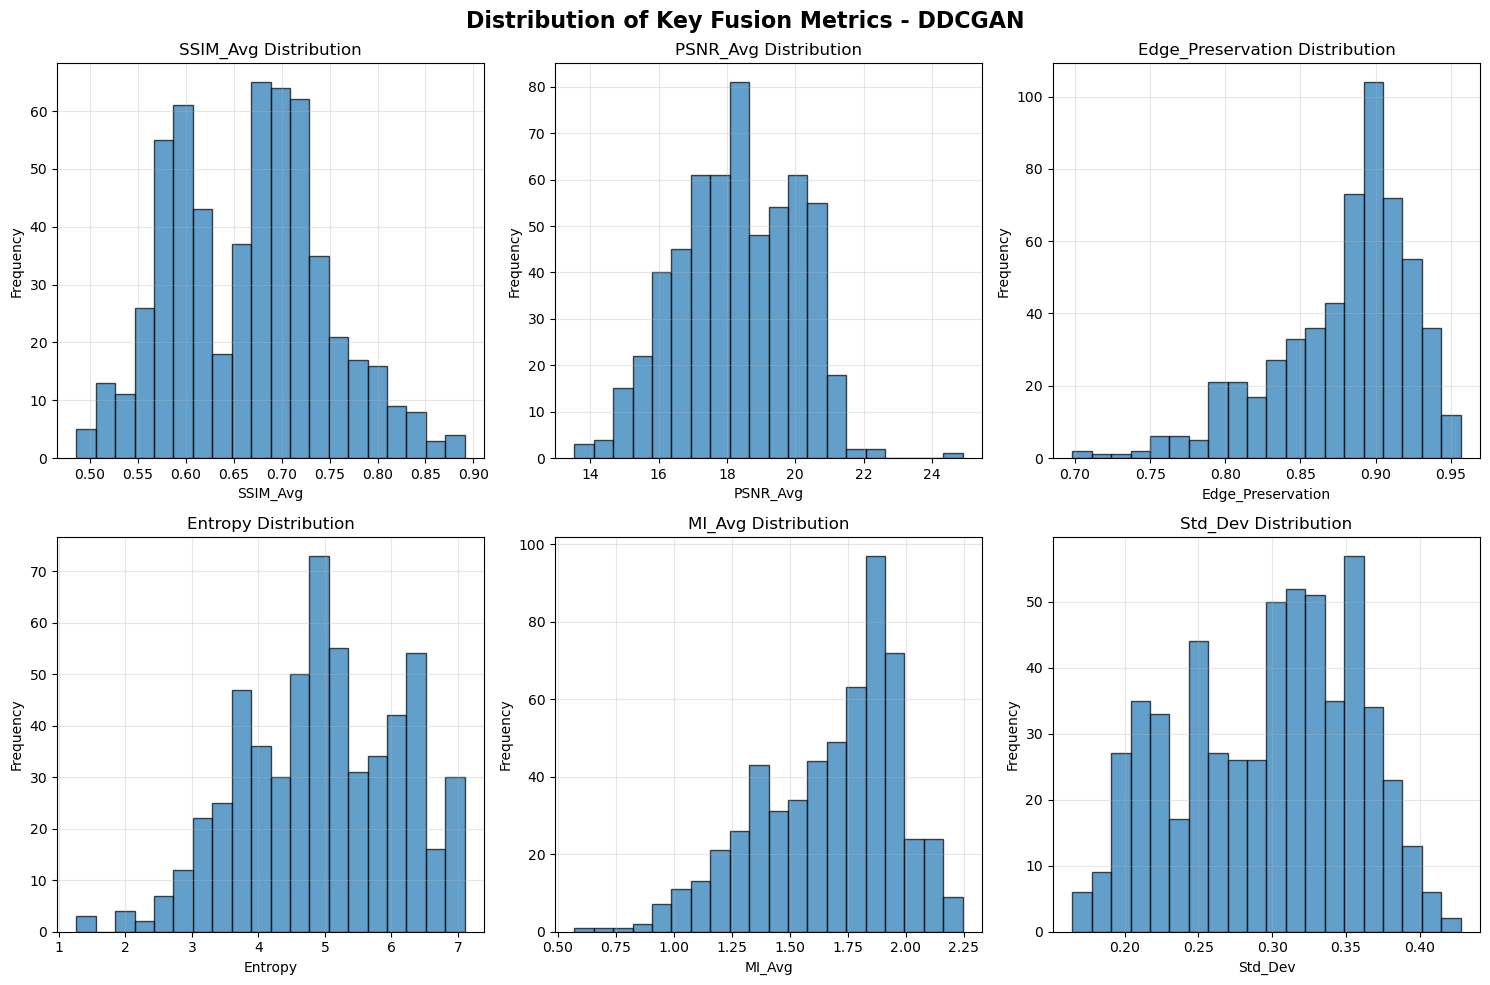

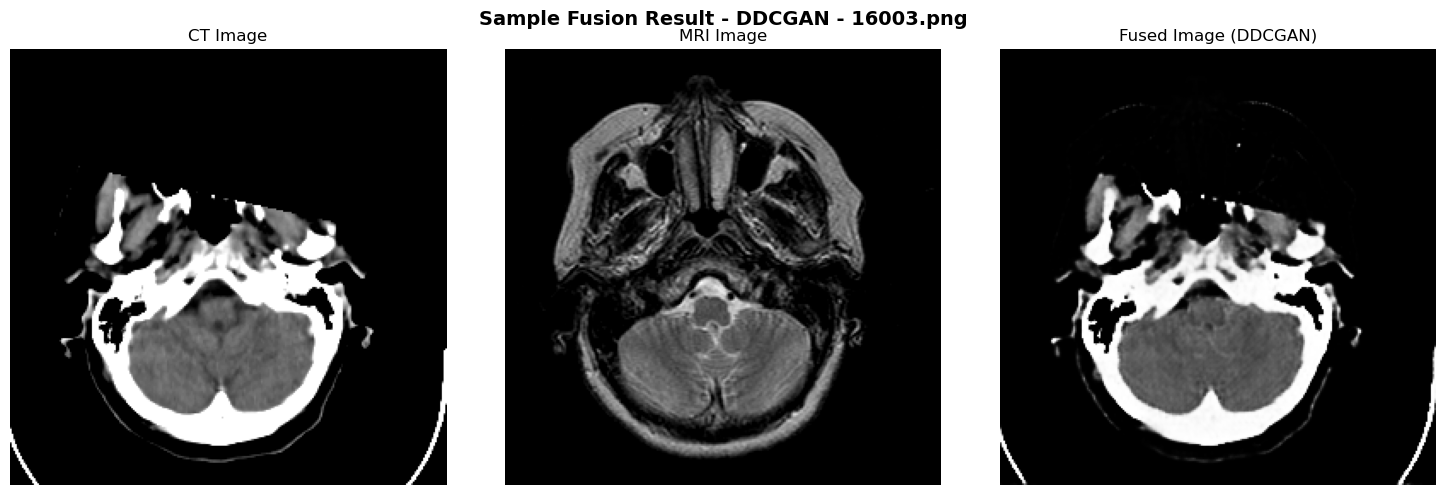


Metrics for sample 0 (16003.png):
----------------------------------------
SSIM_Avg       : 0.6927
PSNR_Avg       : 18.2110
Edge_Preservation: 0.9086
Entropy        : 3.1432
MI_Avg         : 0.9776
Std_Dev        : 0.3046


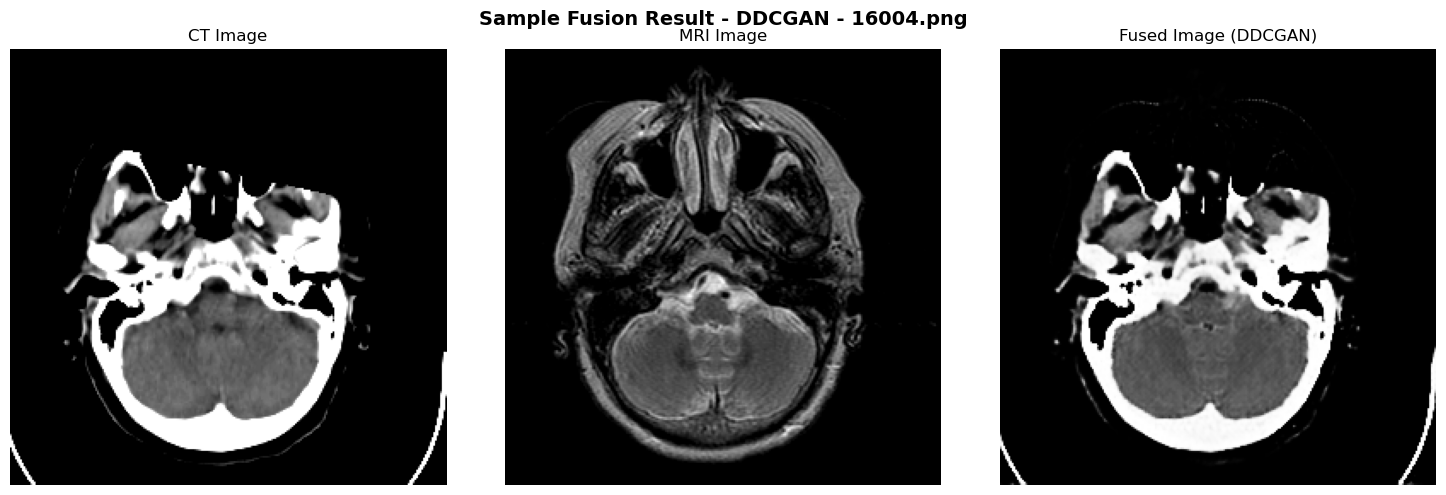


Metrics for sample 1 (16004.png):
----------------------------------------
SSIM_Avg       : 0.6923
PSNR_Avg       : 17.9174
Edge_Preservation: 0.8983
Entropy        : 3.2583
MI_Avg         : 1.0472
Std_Dev        : 0.3232


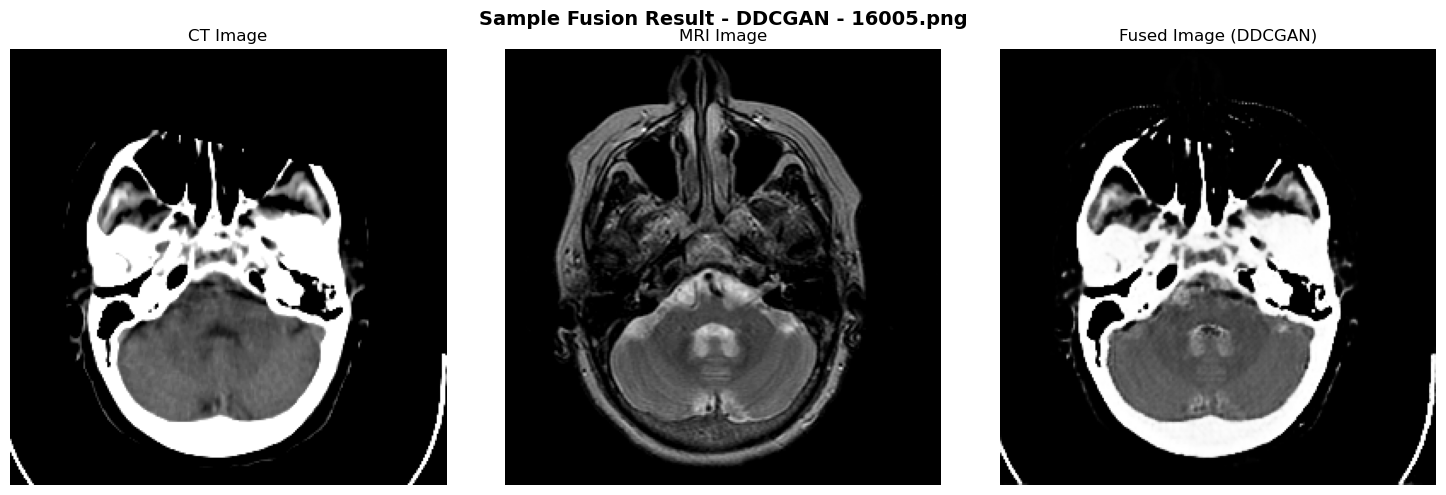


Metrics for sample 2 (16005.png):
----------------------------------------
SSIM_Avg       : 0.6884
PSNR_Avg       : 16.8425
Edge_Preservation: 0.8971
Entropy        : 3.3008
MI_Avg         : 1.0846
Std_Dev        : 0.3490


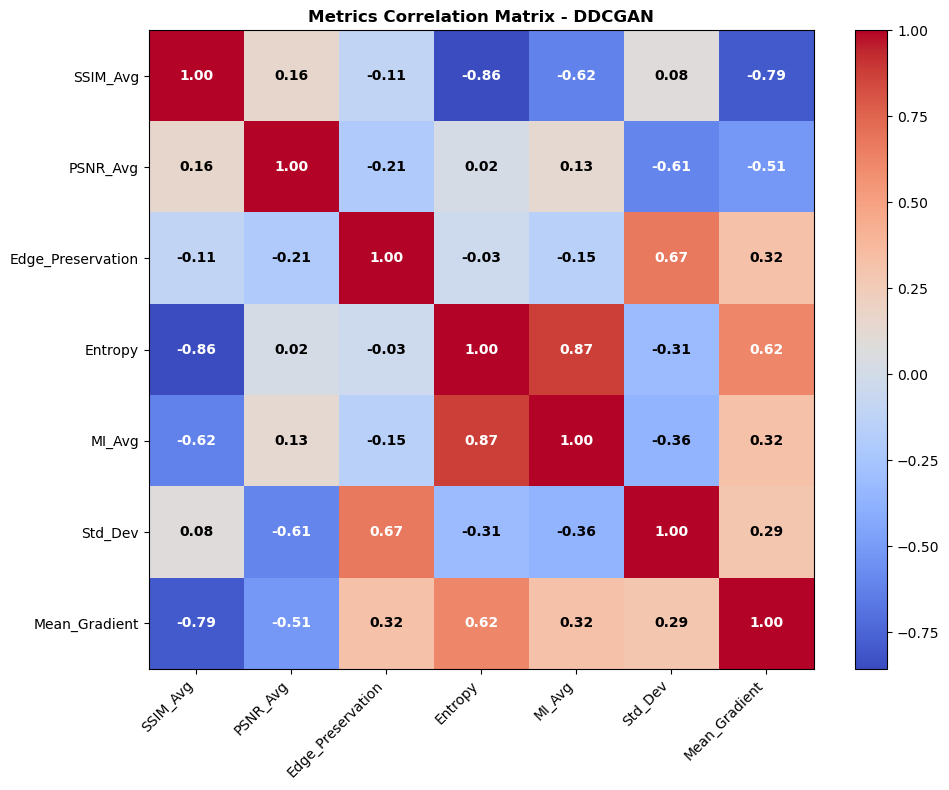


PERFORMANCE SUMMARY - DDCGAN
Total samples tested: 573
Results saved to: test_results/ddcgan_fusion

Best performing sample (SSIM):
  Sample: 41023.png
  SSIM_Avg: 0.8908
  PSNR_Avg: 22.1691

Worst performing sample (SSIM):
  Sample: 45133.png
  SSIM_Avg: 0.4861
  PSNR_Avg: 15.8021

✓ Detailed results saved to test_results/ddcgan_fusion/detailed_metrics.csv
✓ All visualizations saved to results directory


In [7]:
# Visualization of Results
print("Generating visualizations...")

# 1. Metrics Distribution Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Fusion Metrics - DDCGAN', fontsize=16, fontweight='bold')

key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev']
for i, metric in enumerate(key_metrics):
    ax = axes[i//3, i%3]
    ax.hist(metrics_df[metric], bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Distribution')
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'metrics_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Sample Fusion Results Visualization
def visualize_sample_fusion(sample_idx=0):
    """Visualize a sample fusion result."""
    if sample_idx >= len(test_results):
        print(f"Sample index {sample_idx} out of range. Max: {len(test_results)-1}")
        return
    
    sample = test_results[sample_idx]
    metrics = all_metrics[sample_idx]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample Fusion Result - DDCGAN - {sample["key"]}', fontsize=14, fontweight='bold')
    
    # CT image
    axes[0].imshow(sample['ct'], cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    # MRI image
    axes[1].imshow(sample['mr'], cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    # Fused image
    axes[2].imshow(sample['fused'], cmap='gray')
    axes[2].set_title('Fused Image (DDCGAN)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'sample_fusion_{sample_idx}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print metrics for this sample
    print(f"\nMetrics for sample {sample_idx} ({sample['key']}):")
    print("-" * 40)
    for metric in key_metrics:
        if metric in metrics:
            print(f"{metric:15}: {metrics[metric]:.4f}")

# Visualize first few samples
for i in range(min(3, len(test_results))):
    visualize_sample_fusion(i)

# 3. Metrics Correlation Heatmap
correlation_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
corr_matrix = metrics_df[correlation_metrics].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_metrics)), correlation_metrics, rotation=45, ha='right')
plt.yticks(range(len(correlation_metrics)), correlation_metrics)
plt.title('Metrics Correlation Matrix - DDCGAN', fontweight='bold')

# Add correlation values
for i in range(len(correlation_metrics)):
    for j in range(len(correlation_metrics)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'metrics_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4. Performance Summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY - DDCGAN")
print("="*60)
print(f"Total samples tested: {len(test_results)}")
print(f"Results saved to: {results_dir}")
print()

# Best and worst performing samples
best_ssim_idx = metrics_df['SSIM_Avg'].idxmax()
worst_ssim_idx = metrics_df['SSIM_Avg'].idxmin()

print("Best performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[best_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[best_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[best_ssim_idx, 'PSNR_Avg']:.4f}")
print()

print("Worst performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[worst_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[worst_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[worst_ssim_idx, 'PSNR_Avg']:.4f}")

# Save detailed results
metrics_df.to_csv(os.path.join(results_dir, 'detailed_metrics.csv'), index=False)
print(f"\n✓ Detailed results saved to {results_dir}/detailed_metrics.csv")
print("✓ All visualizations saved to results directory")

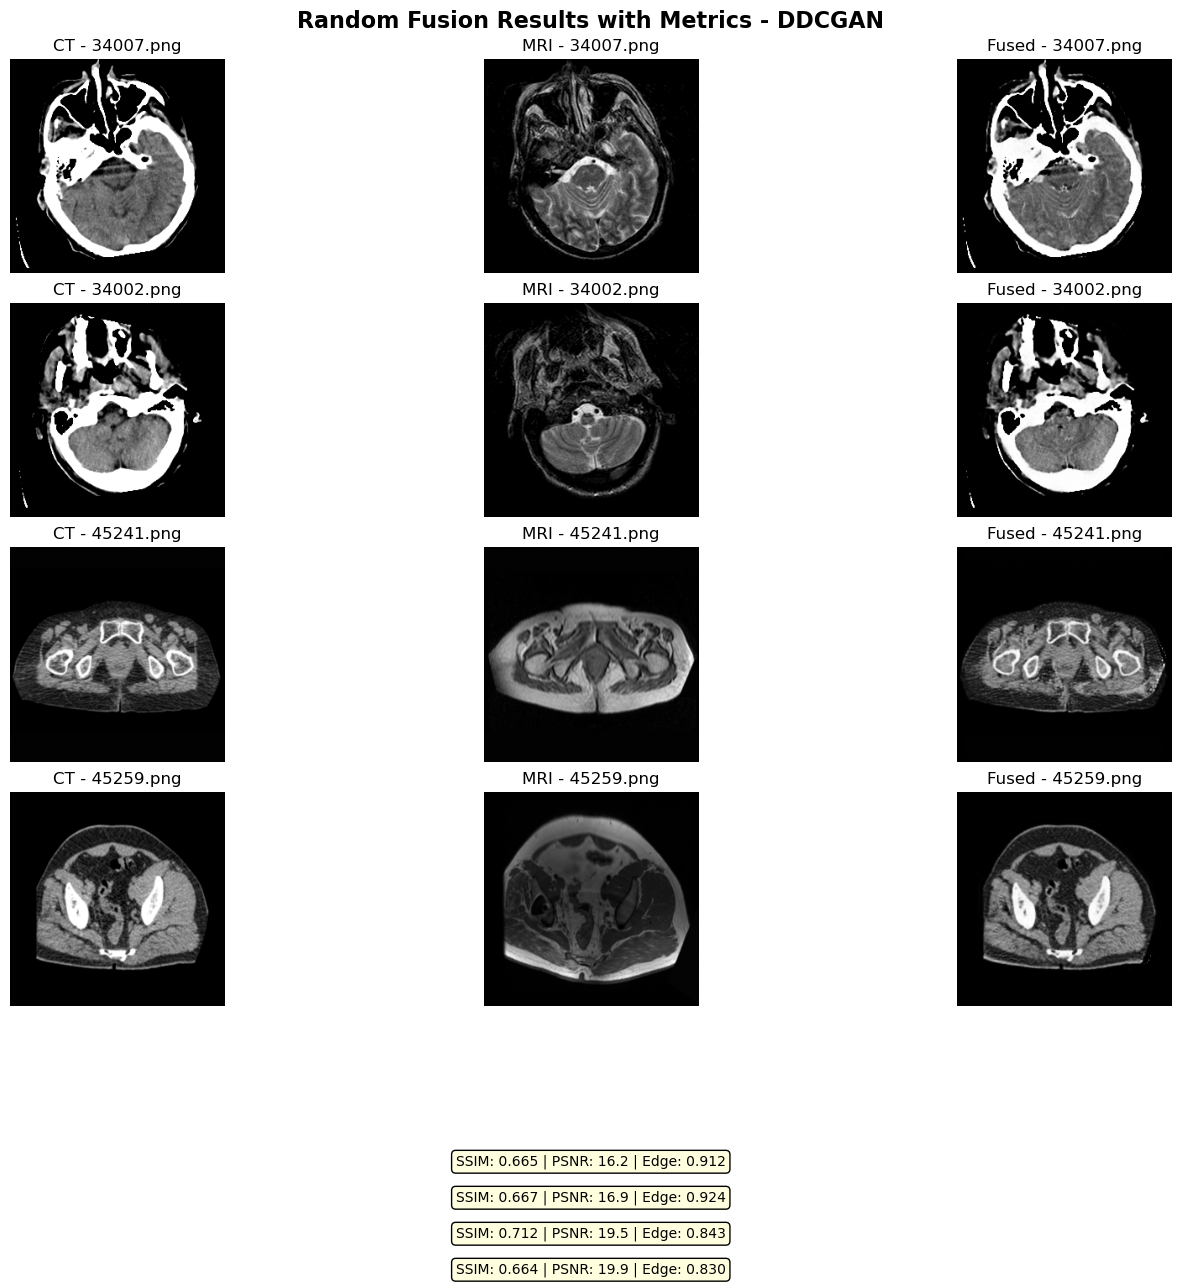


Detailed metrics for 4 random samples:

Sample 1: 34007.png
----------------------------------------
  SSIM_Avg       : 0.6650
  PSNR_Avg       : 16.2005
  Edge_Preservation: 0.9121
  Entropy        : 3.9350
  MI_Avg         : 1.2173

Sample 2: 34002.png
----------------------------------------
  SSIM_Avg       : 0.6667
  PSNR_Avg       : 16.9465
  Edge_Preservation: 0.9244
  Entropy        : 3.7381
  MI_Avg         : 1.1439

Sample 3: 45241.png
----------------------------------------
  SSIM_Avg       : 0.7116
  PSNR_Avg       : 19.5298
  Edge_Preservation: 0.8428
  Entropy        : 4.6805
  MI_Avg         : 1.8487

Sample 4: 45259.png
----------------------------------------
  SSIM_Avg       : 0.6642
  PSNR_Avg       : 19.9333
  Edge_Preservation: 0.8302
  Entropy        : 4.6794
  MI_Avg         : 1.6671


In [8]:
# 2. Random Fusion Results with Metrics
def display_random_fusion_results(test_results, all_metrics, num_samples=4, figsize=(16, 12)):
    """Display random fusion results with their evaluation metrics."""
    if len(test_results) == 0:
        print("No results available!")
        return

    # Select random indices
    random_indices = np.random.choice(len(test_results), min(num_samples, len(test_results)), replace=False)

    # Calculate grid dimensions
    cols = 3  # CT, MRI, Fused
    rows = len(random_indices)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Random Fusion Results with Metrics - DDCGAN', fontsize=16, fontweight='bold')

    for row_idx, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]

        # CT Image
        axes[row_idx, 0].imshow(sample['ct'], cmap='gray')
        axes[row_idx, 0].set_title(f'CT - {sample["key"]}')
        axes[row_idx, 0].axis('off')

        # MRI Image
        axes[row_idx, 1].imshow(sample['mr'], cmap='gray')
        axes[row_idx, 1].set_title(f'MRI - {sample["key"]}')
        axes[row_idx, 1].axis('off')

        # Fused Image
        axes[row_idx, 2].imshow(sample['fused'], cmap='gray')
        axes[row_idx, 2].set_title(f'Fused - {sample["key"]}')
        axes[row_idx, 2].axis('off')

        # Add metrics text below each row
        metrics_text = f"SSIM: {metrics.get('SSIM_Avg', 0):.3f} | PSNR: {metrics.get('PSNR_Avg', 0):.1f} | Edge: {metrics.get('Edge_Preservation', 0):.3f}"

        # Add text below the subplot
        fig.text(0.5, 0.02 - (row_idx * 0.03), metrics_text,
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for metrics text
    plt.savefig(os.path.join(results_dir, 'random_fusion_results.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed metrics for random samples
    print(f"\nDetailed metrics for {len(random_indices)} random samples:")
    print("=" * 80)
    for i, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]
        print(f"\nSample {i+1}: {sample['key']}")
        print("-" * 40)
        key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
        for metric in key_metrics:
            if metric in metrics:
                print(f"  {metric:15}: {metrics[metric]:.4f}")

# Display random fusion results
display_random_fusion_results(test_results, all_metrics, num_samples=4)